### Topic Significance Ranking
- Based on: [Topic Significance Ranking of LDA Generative Models (Alsumait et al.)](https://mimno.infosci.cornell.edu/info6150/readings/ECML09_AlSumaitetal.pdf).
- Data aquisition from [this website](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#3importnewsgroupstextdata) verbatum, with prints removed.


In [54]:
import numpy as np
from scipy.stats import entropy
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize


def TopicSignificanceRanking(count_vector, components, documents):
    '''
    This takes the topics from an LDA model (sklearn) and assigns TSR scores to it.
    
        count_vector: the count vector of the words used in the sklearn model.
    
        components:   the topics generated by the LDA model.
        
        RETURNS TSR for each topic
    
    It is highly probable that this could be done easier than below, and indeed, highly likely.  I was doing this as I read through the paper, and therefore was thinking in terms of matching the text, not in terms of efficiency, except where blindingly obvious.
    Darin LaSota, 5/30/2018
    '''
    # Derived Quantities
    topics = components.shape[0]  # number of topics
    measures = 3
    measure = ['KL','COR','COS']
    
    # Distributions...
    # W-Uniform is a junk topic in which all the terms of the dictionary are equally probable
    W_Uniform = np.ones(components.shape)/count_vector.shape[1]
    #W_Uniform = W_Uniform/np.sum(W_Uniform)
    # As an aside, would probability that word appears in the entire corpus be useful?
    
    # the vacuous semantic distribution (WVacuous), is deﬁned to be the empirical distribution of the sample set
    W_Vacuous = components / components.sum(axis=1)[:, np.newaxis]
    #W_Vacuous =  W_Vacuous/np.sum( W_Vacuous)
    
    # the background topic (D-BGround) is found equally probable in all the documents.
    D_BGround = np.ones(documents.shape)/documents.shape[0]
    #D_BGround = D_BGround/np.sum(D_BGround)
    
    # Construct U, V, and B for each topic k
    U = np.zeros((topics, measures))
    V = np.zeros((topics, measures))
    B = np.zeros((topics, measures))
   
    for k in range(topics):
        # KL = 0
        U[k, 0] = entropy(components[k,:], W_Uniform[k,:])
        V[k, 0] = entropy(components[k,:],  W_Vacuous[k,:])
        # Averaging distance of each document's word to D-BGround
        B[k, 0] = np.mean(entropy(np.array(documents[:,k]), D_BGround[:,k]))

        # COR
        U[k, 1] = np.correlate(components[k,:], W_Uniform[k,:])
        V[k, 1] = np.correlate(components[k,:],  W_Vacuous[k,:])
        # Averaging distance of each document's word to D-BGround
        B[k, 1] = np.mean(np.correlate(documents[:,k], D_BGround[:,k], mode='valid'))

        # COS
        U[k, 2] = cosine(components[k,:].reshape(-1,1), W_Uniform[k,:].reshape(-1,1))
        V[k, 2] = cosine(components[k,:].reshape(-1,1),  W_Vacuous[k,:].reshape(-1,1))
        # Averaging distance of each document's word to D-BGround
        B[k, 2] = np.mean(cosine(documents[:,k].reshape(-1,1),D_BGround[:,k].reshape(-1,1)))
  
    # 4.1 Standardization Proceedure
    # (10) and (11)
    U1 = np.zeros((topics, measures))
    V1 = np.zeros((topics, measures))
    B1 = np.zeros((topics, measures))
    U2 = np.zeros((topics, measures))
    V2 = np.zeros((topics, measures))
    B2 = np.zeros((topics, measures))
    for k in range(topics):
        for m in range(measures):
            # (10)
            U1[k,m] = U[k,m] * (1 - U[k,m]/np.sum(U[:,m], axis=0))
            V1[k,m] = V[k,m] * (1 - V[k,m]/np.sum(V[:,m], axis=0))
            B1[k,m] = B[k,m] * (1 - B[k,m]/np.sum(B[:,m], axis=0))
            # (11)
            U2[k,m] = (U[k,m] - np.min(U[:,m]))/(np.max(U[:,m]) - np.min(U[:,m]))
            V2[k,m] = (V[k,m] - np.min(V[:,m]))/(np.max(V[:,m]) - np.min(V[:,m]))
            B2[k,m] = (B[k,m] - np.min(B[:,m]))/(np.max(B[:,m]) - np.min(B[:,m]))
    
    # correction term to deal with all the same answer
    # only happens when C - Cmin = 0 since Cmax - Cmin = 0
    U1 = np.nan_to_num(U1)
    V1 = np.nan_to_num(V1)
    B1 = np.nan_to_num(B1)
    U2 = np.nan_to_num(U2)
    V2 = np.nan_to_num(V2)
    B2 = np.nan_to_num(B2)
 
    # 4.2 Intra-Criterion Weighted Linear Combination
    S1 = (U1 + V1 + B1)/3
    S2 = (U2 + V2 + B2)/3
    # 4.3 Inter-Criterion Weighted Combination
    '''
        no indication of the proper way to mcalculate psi in the literature, except for the line: 
        These weights are assumed to sum to 1 so that the total score remains bounded between zero and one.
        so, setting them all equal to each other... 1/(topics*measures)
    '''
    psi = np.ones(S1.shape)
    S = S1[:,2]*(psi[:,0] * S1[:,0] + psi[:,1]*S1[:,1])  #(13)
    Psi = psi[:,0] * S2[:,0] + psi[:,1] * S2[:,1] + psi[:,2] * S2[:,2]
    Psi = Psi/np.sum(Psi)
    
    # 4.4 The Final Topic Significance Score
    return Psi*S


In [26]:
# Data import on its own line
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import re, nltk, gensim, spacy
from nltk.stem import WordNetLemmatizer
import pandas as pd


df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')


# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]



def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))



def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)
count_vector = data_vectorized
print(count_vector.shape)

(11314, 9751)


In [27]:
from sklearn.decomposition import LatentDirichletAllocation


model = LatentDirichletAllocation(n_components=40, verbose=1, max_iter=10)
documents = model.fit_transform(count_vector)
components = model.components_

C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [55]:
TSR = TopicSignificanceRanking(count_vector, components, documents)
TSR

0.025 46.4876062274


array([ 0.42881291,  0.89118076,  1.24293397,  0.75079624,  8.51600777,
        1.0067022 ,  1.74770716,  0.51211611,  0.62067601,  0.59786184,
        1.64676098,  0.35761132,  1.42404746,  0.4654423 ,  0.98719928,
        0.42168306,  0.65345899,  2.42510744,  5.30543265,  2.0379476 ,
        0.97748811,  2.17873549,  0.43099907,  0.53854462,  0.69179852,
        0.30674046,  2.29927025,  0.92220221,  0.43212932,  0.50565494,
        0.88285614,  1.00943467,  1.04283408,  0.37355031,  0.35715197,
        0.3736309 ,  1.23482862,  0.84881577,  0.86017179,  1.34731091])

In [61]:
for i in list(TSR.argsort()[-5:][::-1]):
    print()
    print('TOPIC {}'.format(i))
    print(TSR[i])
    for j in list(components[i,:].argsort()[-5:][::-1]):
        print(vectorizer.get_feature_names()[j], components[i,j])



TOPIC 4
8.51600776912
post 4804.32507328
host 4259.00502425
nntp 4193.11562162
organization 3426.8692132
line 3419.84254607
subject 3384.6105077
edu 2512.60987618

TOPIC 18
5.30543264975
max 4414.53059608
server 848.243310229
image 374.381535012
ground 368.259092029
wire 361.247140459
circuit 333.103971837
client 283.328076105

TOPIC 17
2.42510744396
card 1346.2524266
video 398.595143369
slot 171.102095462
cover 169.627994199
accelerator 165.969813159
fpu 140.621357728
ati 140.568640692

TOPIC 26
2.29927025164
line 3899.78910623
subject 3290.74717149
organization 2918.72231786
thank 1897.23454763
know 1564.72222294
university 1529.56270564
mail 1461.34872877


### Validity Testing
First, test multiple runs of same number of topics (dif max_iter) then on dif topic numbers, to see if topic numbers have a greater effect on the mean than the 'actual' significance of the topics.

C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


0.025 38.4434883253


C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


0.025 47.4649295106


C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


0.025 41.5942944615


C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


0.025 44.8716723263


C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


0.025 50.1108014915


C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


0.025 47.9341485429


C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


0.025 40.2376932542


C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


0.025 49.0787402016


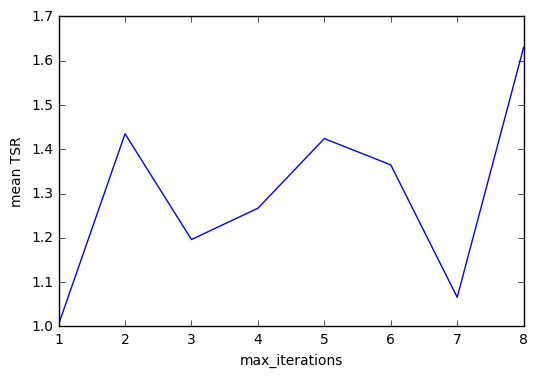

{1: array([ 0.3196945 ,  0.37366253,  0.38938022,  0.3920938 ,  0.40665566,
        0.44128181,  0.46940179,  0.47351604,  0.49174712,  0.50977574,
        0.51596111,  0.53042436,  0.5925677 ,  0.61403263,  0.61634137,
        0.63968613,  0.6400162 ,  0.64284502,  0.65400557,  0.65440391,
        0.67886968,  0.77160922,  0.79340939,  0.82315955,  0.85021852,
        0.88217467,  0.90576352,  0.92653719,  0.9429575 ,  0.97960423,
        0.99287963,  1.09162818,  1.12954486,  1.24861115,  1.27629947,
        1.29589749,  1.77785047,  1.89331124,  2.34361706,  8.21287225]), 2: array([  0.17614018,   0.23873372,   0.38754433,   0.40144543,
         0.41519343,   0.42444403,   0.45706516,   0.46089967,
         0.4935292 ,   0.52821469,   0.55514444,   0.57868437,
         0.5959782 ,   0.60767685,   0.61762958,   0.62096244,
         0.62511444,   0.64649276,   0.6551271 ,   0.66767097,
         0.72651697,   0.7465828 ,   0.75263739,   0.76691958,
         0.77305463,   0.78723312,   

In [62]:
import matplotlib.pyplot as plt

X = [1+a for a in range(8)]
Y = []
Ym = {}
for x in X:
    model = LatentDirichletAllocation(n_components=40, max_iter=x)
    documents = model.fit_transform(count_vector)
    components = model.components_
    TSR = TopicSignificanceRanking(count_vector, components, documents)
    Ym[x] = np.sort(TSR)
    Y.append(np.mean(TSR))

plt.plot(X, Y)
plt.xlabel('max_iterations')
plt.ylabel('mean TSR')
plt.show()
print(Ym)

C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


0.2 44.4743065512


C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


0.1 47.4451248297


C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


0.0666666666667 -inf


C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


0.05 43.3893887301


C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


0.04 39.5116763137


C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


0.0333333333333 44.6759784927


C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


0.0285714285714 42.8920510095


C:\Users\Darin\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


0.025 42.5337265882


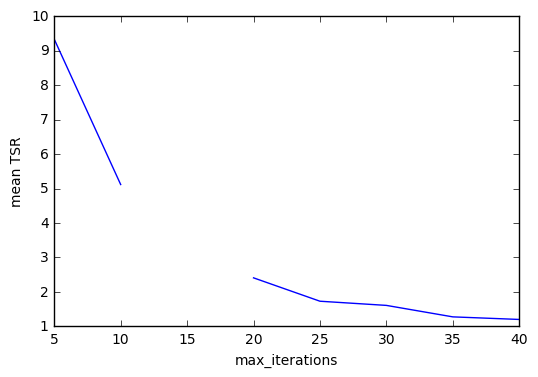

{35: array([ 0.37364242,  0.48296293,  0.49573377,  0.50790845,  0.51878514,
        0.57371009,  0.57669695,  0.59196851,  0.60112674,  0.6084731 ,
        0.68412394,  0.69459398,  0.69673319,  0.79236455,  0.79313086,
        0.82858598,  0.87944325,  1.04804128,  1.07604577,  1.22811631,
        1.27200812,  1.27660902,  1.3185189 ,  1.38176406,  1.39188079,
        1.41620488,  1.49382011,  1.49881807,  1.60100906,  1.75761596,
        1.78718623,  2.11599538,  2.33189355,  3.69697257,  6.24999452]), 20: array([  0.38567856,   0.59327244,   0.76593137,   0.8290148 ,
         1.0008259 ,   1.06666208,   1.20824832,   1.22162458,
         1.59255803,   1.60160467,   1.86280135,   1.97803904,
         1.98330028,   2.09033379,   2.24752175,   2.2802204 ,
         3.68606198,   3.75519814,   4.20327219,  13.81833526]), 5: array([  4.52155013,   5.38747742,   9.1412668 ,  13.29150319,  14.34214184]), 40: array([  0.2544078 ,   0.29492916,   0.3189035 ,   0.3608374 ,
         0.41102723

In [63]:
X = [5 + 5*a for a in range(8)]
Y = []
Ym = {}
for x in X:
    model = LatentDirichletAllocation(n_components=x, max_iter=5)
    documents = model.fit_transform(count_vector)
    components = model.components_
    TSR = TopicSignificanceRanking(count_vector, components, documents)
    Ym[x] = np.sort(TSR)
    Y.append(np.mean(TSR))

plt.plot(X, Y)
plt.xlabel('max_iterations')
plt.ylabel('mean TSR')
plt.show()
print(Ym)